# extrapolating iphone's width
## steps:
start from iphone's template parameters, <br>
extrapolate to samsungs' width range, <br>
see how bignet's confidence react to such change.

## output:
in extrapolation/iphone_w, multiple (100) SVGs from small->big width
in extrapolation/iphone_w/trained_bignet1_naug_norm.pt, brand-related ablation results, <br>
and width (x.pkl) - confidence (y.pkl) pair, which can also be found [here](https://drive.google.com/file/d/1rNrJRgjR0uQzbKcwXC4Effu0Dcy6R0hI/view?usp=sharing)

In [1]:
import util as u
import numpy as np
import os
import copy

In [6]:
fig_folder="figure"
iphone_par=u.load_item("iphone_par.pkl")
# samsung_par=u.load_item("samsung_par.pkl")

In [7]:
iphone_ref=u.iphone_interpolation\
(0.5,notch_random=0, lens_random=np.array([[[0,0,0,1]]]))
samsung_ref=u.samsung_interpolation(0.5)
iphone_observe=copy.deepcopy(iphone_ref)
samsung_observe=copy.deepcopy(samsung_ref)

In [15]:
'''dataset: speaker at middle, no camera, prediction of norm and avg'''
import matplotlib.pyplot as plt
extra_folder="extrapolation"
iphone_folder=extra_folder+"/iphone_w"
u.initialize([iphone_folder])
temp_seed=1

iphone_ref=u.iphone_interpolation\
(0.5,notch_random=0, lens_random=np.array([[[0,0,0,0]]]))

iphone_observe=copy.deepcopy(iphone_ref)
data_size=(1,100)
target="w"
low, up = 60, 100
target_array=np.linspace(low, up, data_size[1])

for i in iphone_observe:
    if i=="lens_random":
        iphone_observe[i]=np.ones((data_size[0],data_size[1],4))*\
        np.array([0,0,0,0])
    elif iphone_ref[i][0][0]==None:
        iphone_observe[i]=np.zeros(data_size)
    elif i==target:
        iphone_observe[i]=\
        np.expand_dims(target_array,0)
    else:
        iphone_observe[i]=np.ones(data_size)*iphone_ref[i][0][0]
        
u.create_iphone_dataset(iphone_observe, iphone_folder,\
                      draw_nodes=0, stroke_aug=0, stripe=0, extra=1)


iphone_path=u.get_filelist(dir,iphone_folder)

#exclude the generated other curves
exclude_group=[ x for x in iphone_path if "group" not in x ]
exclude=[ x for x in exclude_group if "curve" not in x ]
exclude_sorted=u.sort_list(exclude)

norm_pred_rec=[]
avg_pred_rec=[]

model_path="trained_bignet1_naug_norm.pt"
mode1="norm"

for pic_path in exclude_sorted:
    _, norm_iphone_pred=u.test1svg(model_path, pic_path, brand="iphone", resample=1,\
                prediction=1, ablation=iphone_folder+"/"+model_path,\
                mode=mode1, temp_seed=temp_seed)
    norm_pred_rec.append(norm_iphone_pred[0][0])

# plt.plot(target_array, norm_pred_rec, linewidth=3)

In [16]:
x_path = "%s/%s/x.pkl"%(iphone_folder,model_path)
y_path = "%s/%s/y.pkl"%(iphone_folder,model_path)
u.dump_item(target_array, x_path)
u.dump_item(norm_pred_rec, y_path)

# plotting the confidence with individual brand's range

In [17]:
target_array = u.load_item(x_path)
norm_pred_rec2=u.load_item(y_path)

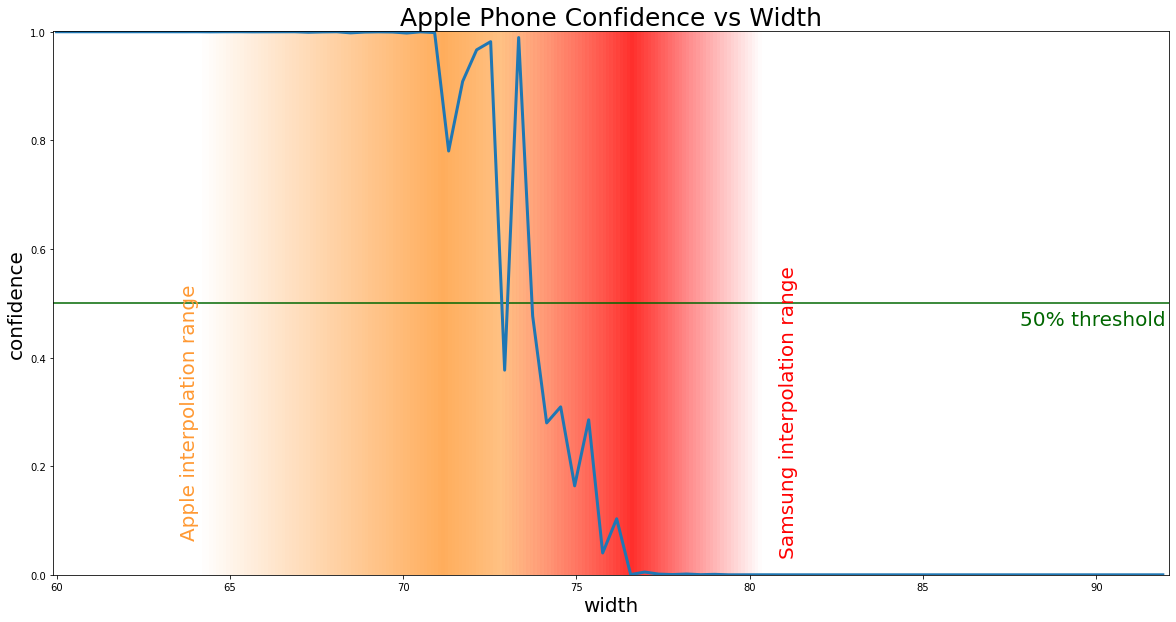

In [19]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
title="Apple Phone Confidence vs Width"
low, up =60,100
pad=0.1
bound_c=[1,0.6,0.2]
l_in, r_in=\
iphone_par["w_par"]["min"],iphone_par["w_par"]["max"]
plt.figure(figsize=(20,10))
u.plot_rainbow(l_in, r_in, alpha_end=0.01, color=bound_c)
plt.text(l_in-pad, 0.3, 'Apple interpolation range', ha='right',\
         rotation=90, va='center', fontsize=20, color=bound_c)

iphone_h=(iphone_par["h_par"]["min"]+iphone_par["h_par"]["min"])/2
samsung_h_avg=(samsung_par["h_par"]["min"]+samsung_par["h_par"]["min"])/2

norm_r=iphone_h/samsung_h_avg

l_in2=(69.1-2*7.415)/154.55*146.15+2*10.75
r_in2=(77.1-2*7.415)/154.55*146.15+2*10.75

bound_c2=[1,0,0]
u.plot_rainbow(l_in2, r_in2, alpha_end=0.01, color=bound_c2)
plt.text(r_in2+10*pad, 0.3, 'Samsung interpolation range', ha='right',\
         rotation=90, va='center', fontsize=20, color=bound_c2)

plt.hlines(0.5, low-0.1, up+0.1,color=[0,0.4,0])
plt.text(low+0.8*(up-low)+0.01, 0.47, '50% threshold', ha='right',\
         va='center', fontsize=20, color=[0,0.4,0])

plt.axis((low-0.1,low+0.8*(up-low)+0.1,0,1.001))
plt.title(title, fontsize=25)
plt.xlabel("width", fontsize=20)
plt.ylabel("confidence", fontsize=20)


plt.plot(target_array[:80], norm_pred_rec2[:80], linewidth=3,label="norm mid")
# plt.plot(target_array[:80], norm_pred_rec[:80], linewidth=3,label="norm mid")
plt.savefig("%s.jpg"%title, bbox_inches='tight')